### 오토인코더 + 분류기 결합 모형

In [1]:
# classifier-autoencoder
# Autoencoder = Encoder + Classifier/Decoder
# 분류기의 기능이 추가된 오토인코더 모형

import numpy as np
import keras
from keras.layers import Activation, Dense, Dropout, Input, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import Reshape, Conv2DTranspose, UpSampling2D
from keras.models import Model
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.callbacks import TensorBoard
from keras import backend as K
import math
import matplotlib.pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
# 전처리
num_labels = np.amax(y_train) + 1

# 원-핫 인코딩
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

image_size = x_train.shape[1]

x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [4]:
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
pool_size = 2
dropout = 0.4
filters = 16
latent_dim = 16

In [5]:
# 1. 인코더 모형

inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

for i in range(2):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    filters = filters * 2
    x = Conv2D(filters=filters, kernel_size=kernel_size,
               padding='same')(x)
    x = MaxPooling2D()(x)

shape = x.shape.as_list()
x = Flatten()(x)

latent = Dense(latent_dim, name='latent_vector')(x)
encoder = Model(inputs, latent, name='encoder')

encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 1)        4         
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 32)       128 

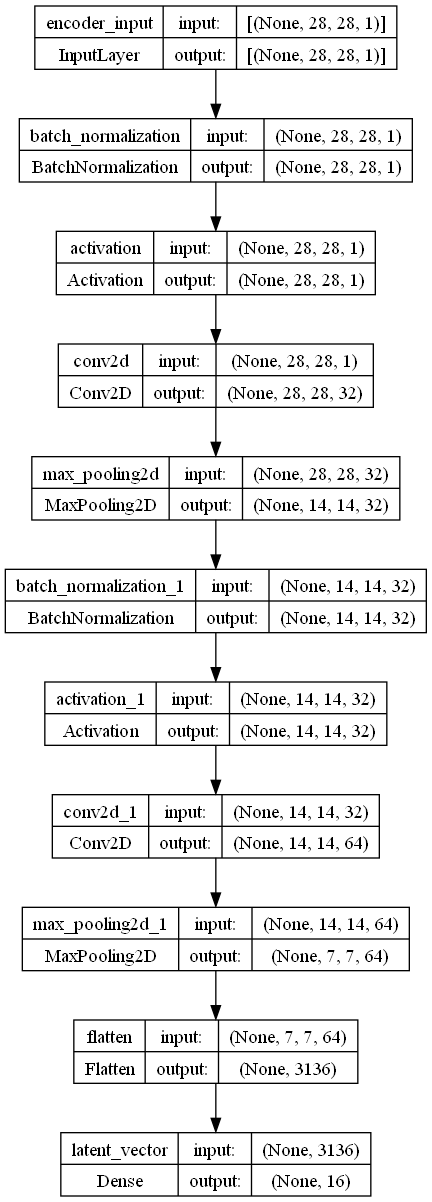

In [6]:
plot_model(encoder, to_file='classifier-encoder.png', show_shapes=True)

In [18]:
# 입력 이미지 크기: 4x4, 채널: 3 
input_shape = (4, 4, 3)

layer = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(3, 3), input_shape=input_shape)

a = tf.random.normal(shape=(1, *input_shape))  
b = layer(a)
print(a.shape)
print(b.shape)

(1, 4, 4, 3)
(1, 6, 6, 3)


In [7]:
# 2. 디코더 모형

latent_inputs = Input(shape=(latent_dim,), name='decoder_input')

x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(filters=filters, kernel_size=kernel_size,
#          역합성곱층
                        padding='same')(x)
    x = UpSampling2D()(x)
#          업샘플링
    filters = int(filters / 2)

x = Conv2DTranspose(filters=1, kernel_size=kernel_size,
                    padding='same')(x)

outputs = Activation('sigmoid', name='decoder_output')(x)
decoder = Model(latent_inputs, outputs, name='decoder')

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 16)]              0         
                                                                 
 dense (Dense)               (None, 3136)              53312     
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 batch_normalization_2 (Batc  (None, 7, 7, 64)         256       
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 64)         36928     
 nspose)                                                   

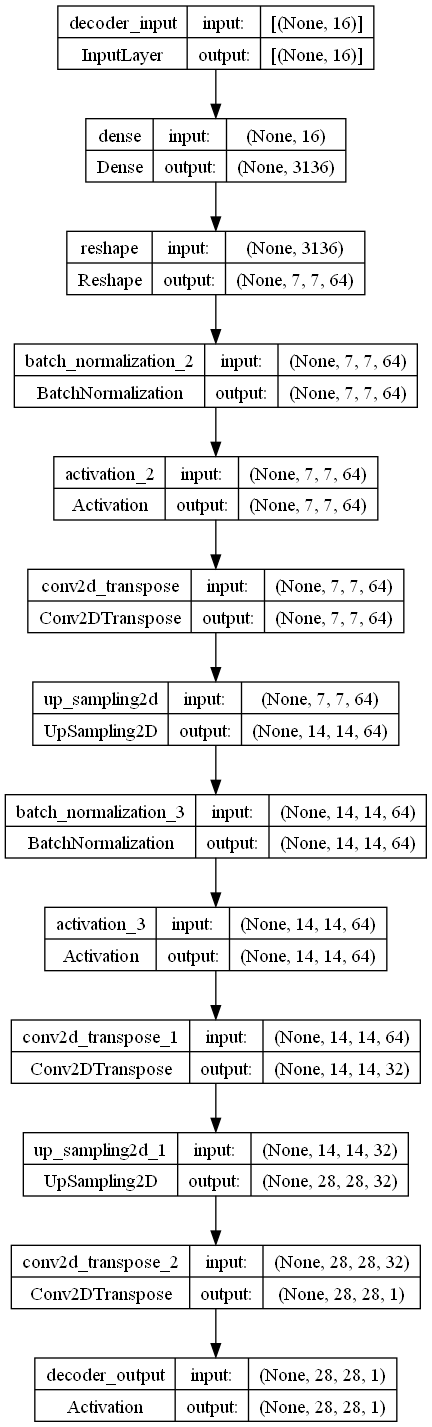

In [8]:
plot_model(decoder, to_file='classifier-decoder.png', show_shapes=True)

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import UpSampling2D

# 4개의 이미지, 이미지 크기: 8x8, 채널: 3
a = tf.random.normal(shape=(4, 8, 8, 3))  
# 8x8 이미지를 16x16 이미지로 업샘플링
layer = UpSampling2D(size=(2, 2)) 
b = layer(a)

print(a.shape)
print(b.shape)

(4, 8, 8, 3)
(4, 16, 16, 3)


In [10]:
# 3.분류기 모형

latent_inputs = Input(shape=(latent_dim,), name='classifier_input')

x = Dense(512)(latent_inputs)
x = Activation('relu')(x)
x = Dropout(0.4)(x)

x = Dense(256)(x)
x = Activation('relu')(x)
x = Dropout(0.4)(x)

x = Dense(num_labels)(x)

classifier_outputs = Activation('softmax', name='classifier_output')(x)
classifier = Model(latent_inputs, classifier_outputs, name='classifier')

classifier.summary()

Model: "classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 classifier_input (InputLaye  [(None, 16)]             0         
 r)                                                              
                                                                 
 dense_4 (Dense)             (None, 512)               8704      
                                                                 
 activation_6 (Activation)   (None, 512)               0         
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 activation_7 (Activation)   (None, 256)               0         
                                                        

                                                                 
Total params: 142,602
Trainable params: 142,602
Non-trainable params: 0
_________________________________________________________________


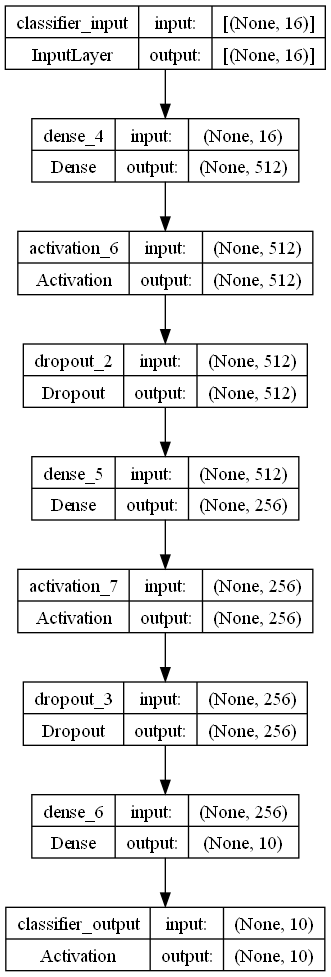

In [11]:
plot_model(classifier, to_file='classifier.png', show_shapes=True)

In [12]:
# 4.오토인코더 모형 , Autoencoder = Encoder + Classifier/Decoder

autoencoder = Model(inputs,
                    [classifier(encoder(inputs)), decoder(encoder(inputs))],
                    name='autodecoder')

autoencoder.compile(loss=['categorical_crossentropy', 'mse'],
                    optimizer='adam',
                    metrics=['accuracy', 'mse'])

autoencoder.summary()

Model: "autodecoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder (Functional)           (None, 16)           69140       ['encoder_input[0][0]',          
                                                                  'encoder_input[0][0]']          
                                                                                                  
 classifier (Functional)        (None, 10)           142602      ['encoder[0][0]']                
                                                                                                  
 decoder (Functional)           (None, 28, 28, 1)    109505      ['encoder[1][0]']      

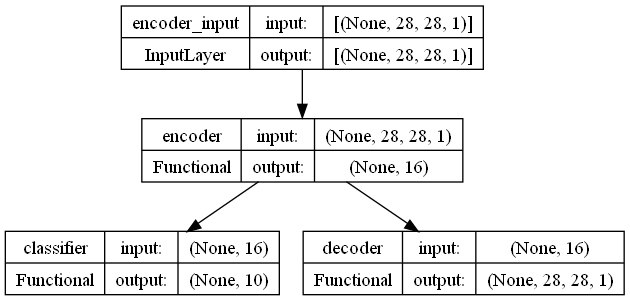

In [13]:
plot_model(autoencoder, to_file='classifier-autoencoder.png', show_shapes=True)

In [14]:
autoencoder.fit(x_train, [y_train, x_train],
                validation_data=(x_test, [y_test, x_test]),
                epochs=2, batch_size=batch_size,
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/2
469/469 [==============================] - 40s 33ms/step - loss: 0.2387 - classifier_loss: 0.2036 - decoder_loss: 0.0351 - classifier_accuracy: 0.9356 - classifier_mse: 0.0092 - decoder_accuracy: 0.8017 - decoder_mse: 0.0351 - val_loss: 0.0793 - val_classifier_loss: 0.0537 - val_decoder_loss: 0.0256 - val_classifier_accuracy: 0.9831 - val_classifier_mse: 0.0026 - val_decoder_accuracy: 0.8075 - val_decoder_mse: 0.0256
Epoch 2/2
469/469 [==============================] - 15s 31ms/step - loss: 0.0902 - classifier_loss: 0.0668 - decoder_loss: 0.0234 - classifier_accuracy: 0.9794 - classifier_mse: 0.0031 - decoder_accuracy: 0.8075 - decoder_mse: 0.0234 - val_loss: 0.0835 - val_classifier_loss: 0.0611 - val_decoder_loss: 0.0224 - val_classifier_accuracy: 0.9821 - val_classifier_mse: 0.0028 - val_decoder_accuracy: 0.8074 - val_decoder_mse: 0.0224


In [15]:
y_predicted, x_decoded = autoencoder.predict(x_test)

print(np.argmax(y_predicted[:8], axis=1))

313/313 [==============================] - 2s 4ms/step
[7 2 1 0 4 1 4 9]


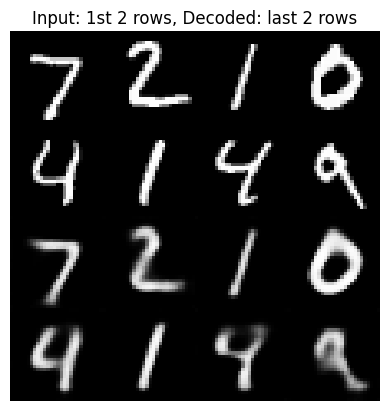

In [16]:
imgs = np.concatenate([x_test[:8], x_decoded[:8]])
imgs = imgs.reshape((4, 4, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])

plt.figure()
plt.axis('off')
plt.title('Input: 1st 2 rows, Decoded: last 2 rows')
plt.imshow(imgs, interpolation='none', cmap='gray')

plt.show()